In [1]:
# setup needed Py packages:
import numpy as np
import win32com.client
import deap
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

In [2]:
# Instantiate the main OpenDSS Object:
try:
    dssObj = win32com.client.Dispatch("OpenDSSengine.DSS")
except:
    print ("Unable to start the OpenDSS Engine")
    raise SystemExit

In [3]:
# Instantiate the other OpenDSS Object:
dssText = dssObj.Text  # Definiranje tekstualnog objekta
dssCircuit = dssObj.ActiveCircuit  # Definiranje objekta mreze
dssSolution = dssCircuit.Solution  # Definiranje objekta rjesenja
dssElem = dssCircuit.ActiveCktElement  # Definiranje objekta elementa mreze

In [11]:
# Compail the OpenDSS file
dssText.Command = r"Compile 'C:\Users\mimit1\Documents\OpenDSS\Exercise3dss.dss'"
#dssText.Command = r"Compile 'C:\Users\Barukcic\Documents\OpenDSS\Exercise3dss.dss'"

In [12]:
# Get node names:
NodeN = dssCircuit.AllNodeNames
# and print them:
print (NodeN)

('sour.1', 'sour.2', 'sour.3', 'b2.1', 'b2.2', 'b2.3', 'b3.1', 'b3.2', 'b3.3', 'b4.1', 'b4.2', 'b4.3', 'b5.1', 'b5.2', 'b5.3', 'b6.1', 'b6.2', 'b6.3', 'b7.1', 'b7.2', 'b7.3', 'b8.1', 'b8.2', 'b8.3', 'b9.1', 'b9.2', 'b9.3', 'b10.1', 'b10.2', 'b10.3', 'b11.1', 'b11.2', 'b11.3', 'b12.1', 'b12.2', 'b12.3', 'b13.1', 'b13.2', 'b13.3', 'b14.1', 'b14.2', 'b14.3', 'b15.1', 'b15.2', 'b15.3', 'b16.1', 'b16.2', 'b16.3', 'b17.1', 'b17.2', 'b17.3', 'b18.1', 'b18.2', 'b18.3', 'b19.1', 'b19.2', 'b19.3', 'b20.1', 'b20.2', 'b20.3', 'b21.1', 'b21.2', 'b21.3', 'b22.1', 'b22.2', 'b22.3', 'b23.1', 'b23.2', 'b23.3', 'b24.1', 'b24.2', 'b24.3', 'b25.1', 'b25.2', 'b25.3', 'b26.1', 'b26.2', 'b26.3', 'b27.1', 'b27.2', 'b27.3', 'b28.1', 'b28.2', 'b28.3', 'b29.1', 'b29.2', 'b29.3', 'b30.1', 'b30.2', 'b30.3', 'b31.1', 'b31.2', 'b31.3', 'b32.1', 'b32.2', 'b32.3', 'b33.1', 'b33.2', 'b33.3', 'b34.1', 'b34.2', 'b34.3')


In [13]:
# Repeat for bus names:
BusN = dssCircuit.AllBusNames
print (BusN)

('sour', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b34')


In [14]:
# Get some properties of the load element:
dssCircuit.Loads.Name = 'L2'
VL2 = dssCircuit.Loads.kV
PL2 = dssCircuit.Loads.kW
QL2 = dssCircuit.Loads.kvar
# and print them:
print ('Nominal voltage of load L2 is: ', VL2, 'kV \n',
       'Nominal active power of L2 is: ', PL2, 'kW \n',
       'Nominal reactive power of L2 is: ', QL2, 'kvar \n',
       'and complex power of L2 is: ', complex(PL2, QL2), 'kVA')

Nominal voltage of load L2 is:  11.0 kV 
 Nominal active power of L2 is:  230.0 kW 
 Nominal reactive power of L2 is:  142.5 kvar 
 and complex power of L2 is:  (230+142.5j) kVA


In [103]:
# Let's make the objective function of the optimization problem of optimal allocation of DG in the distribution network in form of PY function:
def FC(ind, *addtnP):
    # decoding DG allocation from DE individual
    LOCdg = int(round(ind[0]))  # decode DG location from DE individual
    # print (type(LOCdg)) - control line
    Pdg = ind[1]  # decode DG powers from DE individual
    Qdg = ind[2]
    
    # change DG location and power in OpenDSS script:
    dssText.Command = 'Edit generator.DG' + ' bus1=' + BusN[LOCdg] + ' kw=' + str(Pdg) + ' kvar=' + str(Qdg)

    # execute simulation with changed DG location and powers:
    dssSolution.Solve()
    
    # get nodal voltages, maximum and minimum voltages in [p.u]
    Vpu = dssCircuit.AllBusVmagPU
    Vmax = max(Vpu)
    Vmin = min(Vpu)
    
    # get network loosses
    # this is the first objective function in MOOP
    f1 = dssCircuit.Losses[0]/1000  # divide by 1000 to get numerical value in [kW]
    
    # check inequality constraints and penalize OF if they not satisfied (soft penalisation):
    if Vmax > Vu:
        NL = (1+Vmax-Vu)*NL
    if Vmin < Vl:
        NL = (1+Vl-Vmin)*NL
    # define measure of voltage profile flatness as the secodne objective in MOOP
    f2 = Pdg #Qdg #Vmax - Vmin
    
    # use network losses as objective function value
    return f1, f2, Vmin, Vmax

def OF(ind, addtnP):
    FNC = FC(ind, *addtnP)
    return FNC[0], FNC[1]

In [104]:
# set voltage limits in [p.u] (inequality constraints)
Vl = 0.9
Vu = 1.1

# and forward them as additional parameters of objective function
addtnP = (Vl, Vu)

In [105]:
# Control cell, check if objective function work well
indp = [9.8, 500.0, 350.0]
NLp = OF(indp, addtnP)
NLpp = FC(indp, addtnP)

# total network losses are:
print ('Active network losses are: ', NLp[0], '[kW]  and Vmax-Vmin is: ', NLp[1], 'p.u.')
print ('Active network losses, min and max voltages are: ', NLpp, '[kW, p.u., p.u., p.u.]')

Active network losses are:  175.67334769486146 [kW]  and Vmax-Vmin is:  500.0 p.u.
Active network losses, min and max voltages are:  (175.67490214546783, 500.0, 0.9437485995484897, 0.9982302021953554) [kW, p.u., p.u., p.u.]


In [106]:
# create fintess and individual DEAP classes:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0)) # two objectives, both minimization
creator.create("Individual", list, fitness=creator.FitnessMin) # EA individual is in form of Python list

# instantiate toolbox class:
toolbox = base.Toolbox()

C:\Users\mimit1\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\mimit1\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [107]:
# define decision variable limits
Ndv = 3 # number of decision variables
# number of busess avaliable for DG instalation
Lmin, Lmax = 0, len(BusN)-1
# Power limits of DG
PDGmin, PDGmax = 0.0, 5000.0
QDGmin, QDGmax = -2000.0, 2000.0

# register decision variables
toolbox.register("LOC", random.randint, Lmin, Lmax) # integer type
toolbox.register("PDG", random.uniform, PDGmin, PDGmax) # float type
toolbox.register("QDG", random.uniform, QDGmin, QDGmax) # float type

# build EA individual:
toolbox.register("ind", tools.initCycle, creator.Individual, (toolbox.LOC, toolbox.PDG, toolbox.QDG), n=1) # individual as sequence of decision variables

# generate initial EA population:
toolbox.register("population", tools.initRepeat, list, toolbox.ind)

In [113]:
# setting EA operators
# crossover (mate):
toolbox.register('mate', tools.cxUniform, indpb=0.5) # uniform crossover with probability of 0.5 for choosing gene from soem of parents

# mutation:
toolbox.register("mutate", tools.mutPolynomialBounded, low=[Lmin, PDGmin, QDGmin], up=[Lmax, PDGmax, QDGmax], eta=2.0, indpb=0.1)

# selection:
toolbox.register("select", tools.selNSGA2) # Pareto ranking sorting from NSGA method

In [114]:
# registre objective function:
toolbox.register("evaluate", OF, addtnP = addtnP) # OF is name of the function in Python and addtnP are additional parameters need for OF calculation

In [131]:
# performe optimization by using DEAP
toolbox.max_gen = 200 # define maximum number of generations in EA
toolbox.pop_size = 20 # define population size (number of individuals in population)
toolbox.mut_prob = 1/Ndv # probability of gene mutation

pop = toolbox.population(toolbox.pop_size)
# start EA
res, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size,
                                     lambda_=toolbox.pop_size,
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob,
                                     stats=None, #s, #None,
                                     ngen=toolbox.max_gen,
                                     verbose=False)
#res


 number of ranks is:  1

 The Pareto front of rank 1 is:  [(46.96850779564804, 2886.405054830937), (48.07626358459516, 2643.4848631150126), (50.34901465522121, 2380.935746032592), (53.04435785186067, 2180.5681004294893), (58.325821802062976, 1926.9756327909847), (64.90796529020753, 1674.2901779645808), (71.48073348805323, 1482.3320594806082), (77.55107411995114, 1334.1608283940936), (83.89973461791139, 1197.9622158369414), (90.18493820072115, 1076.6844571677348), (99.4829833465784, 915.6438590655564), (108.137351331647, 780.0682325825392), (112.0063575680241, 722.9230309837525), (119.80452158088693, 613.6006654070917), (127.57369718428576, 511.4431022311144), (131.43280784536873, 463.0325653190855), (141.07282917953685, 347.0780237347424), (150.72970167687552, 237.4242638857229), (162.16318872016586, 109.68638761046944), (171.41206870587416, 1.2143716326298204)] 



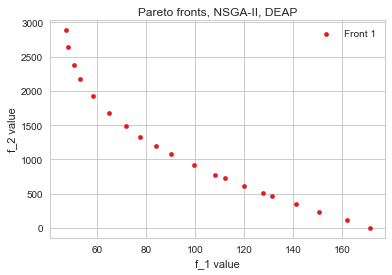

In [132]:
# Show Pareto front
fronts = tools.emo.sortLogNondominated(res, len(res))
plot_colors = seaborn.color_palette("Set1", n_colors=20)
fig, ax = plt.subplots(1)

PFL =[]
for i,inds in enumerate(fronts):
    PFs = [toolbox.evaluate(ind) for ind in inds] # calculate OF value for Pareto set i.e. calculate Pareto fronts (of all ranks)
    df = pd.DataFrame(PFs)
    df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], color=plot_colors[i])#, color=plot_colors[i])
    PFL.append(PFs)
plt.xlabel('f_1 value');plt.ylabel('f_2 value'); plt.title('Pareto fronts, NSGA-II, DEAP')
#ax.set_xlim(46, 48)
#ax.set_ylim(0.01, 0.02)
print('\n number of ranks is: ', len(PFL))
print ('\n The Pareto front of rank 1 is: ', PFL[0], '\n')
if len(PFL) > 1:
    print ('\n The Pareto front of rank 2 is: ', PFL[1], '\n')

In [133]:
# Show the Pareto set as solution of MOOP
print (fronts[0])

[[19.603516970473542, 2886.405054830937, 1782.6243333071354], [19.603516970473542, 2643.4848631150126, 1782.6243333071354], [21.300277928394927, 2380.935746032592, 1687.7437150412095], [21.300277928394927, 2180.5681004294893, 1687.7437150412095], [21.300277928394927, 1926.9756327909847, 1687.7437150412095], [22.347498054007886, 1674.2901779645808, 1522.9731655941152], [22.347498054007886, 1482.3320594806082, 1522.9731655941152], [22.347498054007886, 1334.1608283940936, 1522.9731655941152], [22.347498054007886, 1197.9622158369414, 1522.9731655941152], [22.347498054007886, 1076.6844571677348, 1522.9731655941152], [22.347498054007886, 915.6438590655564, 1522.9731655941152], [22.347498054007886, 780.0682325825392, 1522.9731655941152], [22.347498054007886, 722.9230309837525, 1522.9731655941152], [22.347498054007886, 613.6006654070917, 1522.9731655941152], [22.347498054007886, 511.4431022311144, 1522.9731655941152], [22.347498054007886, 463.0325653190855, 1522.9731655941152], [22.34749805400